In [2]:
# create bankend for Qiskit's AER (QSAM simulator)
from qiskit import Aer
aer_sim = Aer.get_backend('qasm_simulator')
import os
import threading
ionq_token="LAYq6EwdvXqh4sIma2iKZNQ2l7KzbxX6"
from qiskit_ionq import IonQProvider
from qiskit import QuantumCircuit, execute
from threading import Thread, Lock
provider = IonQProvider(ionq_token)

# show supported backends
print(provider.backends()) 

# create backends for simulator and hardware
backend_sim = provider.get_backend("ionq_simulator")
backend_qpu = provider.get_backend("ionq_qpu")

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


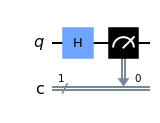

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure(0,0)

qc.draw(output='mpl')

In [4]:
import os
from array import *

#generates n bytes, storing the memory in order to preserve the distribution of the numbers
#Returns a binary array of bytes that can later be outputted to a file.
def gen_n_bytes(filename, bytes):
    job = execute(qc, backend = aer_sim, shots = 8*bytes, memory = True)
    results = job.result()
    memory = results.get_memory(qc)
    
    bin_array = array('B')
    
    for i in range(bytes):
        bitstring = ''.join(map(str, memory[i:i+8])) 
        bin_array.append(int(bitstring,2))
    
    #Now adding the measurement results to a .txt file
    bits = open(filename, "wb")
    
    bin_array.tofile(bits)

In [6]:
#Testing generation time for 1000000 bytes nonthreaded
import time

start = time.time()
gen_n_bytes("non_threaded.bin", 1000000)
t_no_thread = time.time() - start

In [6]:
print(f"Time to generate 1M bytes unthreaded: {t_no_thread} seconds")

Time to generate 1M bytes unthreaded: 113.44296526908875 seconds


In [7]:
import os
from array import *

#generates n bytes, storing the memory in order to preserve the distribution of the numbers
#Returns a binary array of bytes that can later be outputted to a file.
def gen_n_bytes_ret(bytes):
    job = execute(qc, backend = aer_sim, shots = 8*bytes, memory = True)
    results = job.result()
    memory = results.get_memory(qc)
    
    bin_array = array('B')
    
    for i in range(bytes):
        bitstring = ''.join(map(str, memory[i:i+8])) 
        bin_array.append(int(bitstring,2))
    
    return bin_array

In [24]:
#Testing generation time for 10M bytes nonthreaded
import time

start = time.time()
bin_array = gen_n_bytes_ret(10000000)
t_no_thread = time.time() - start

print(f"Time to generate 10M bytes unthreaded: {t_no_thread} seconds")

Time to generate 10M bytes unthreaded: 821.034469127655 seconds


In [25]:
start = time.time()

bits = open("non_threaded.bin", "wb")
bin_array.tofile(bits)
bits.close()

t_IO = time.time() - start

print(f"Time to append 10M bytes to file unthreaded: {t_IO} seconds")

Time to append 10M bytes to file unthreaded: 0.13131403923034668 seconds


In [27]:
import os
from array import *

#Modified slightly with second paramater storing return value instead of returning
#Used with threading
def gen_n_bytes_threaded(bytes, bin_array):
    job = execute(qc, backend = aer_sim, shots = 8*bytes, memory = True)
    results = job.result()
    memory = results.get_memory(qc)   
    
    for i in range(bytes):
        bitstring = ''.join(map(str, memory[i:i+8])) 
        bin_array.append(int(bitstring,2))
    

In [28]:
#Now we add 10 threads splitting the task equally among them

start = time.time()

bin_array1 = array('B')
bin_array2 = array('B')
bin_array3 = array('B')
bin_array4 = array('B')
bin_array5 = array('B')
bin_array6 = array('B')
bin_array7 = array('B')
bin_array8 = array('B')
bin_array9 = array('B')
bin_array10 = array('B')

t1 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array1])
t2 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array2])
t3 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array3])
t4 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array4])
t5 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array5])
t6 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array6])
t7 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array7])
t8 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array8])
t9 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array9])
t10 = Thread(target = gen_n_bytes_threaded, args = [1000000, bin_array10])

t1.start()
t2.start()
t3.start()
t4.start()
t5.start()
t6.start()
t7.start()
t8.start()
t9.start()
t10.start()

t1.join()
t2.join()
t3.join()
t4.join()
t5.join()
t6.join()
t7.join()
t8.join()
t9.join()
t10.join()

t_thread = time.time() - start

print(f"Time to generate 10M bytes using 10 threads at 1M bytes each: {t_thread} seconds")

Time to generate 10M bytes using 10 threads at 1M bytes each: 840.4696788787842 seconds


In [29]:
start = time.time()

bits = open("threaded.bin", "wb")

bin_array1.tofile(bits)
bin_array2.tofile(bits)
bin_array3.tofile(bits)
bin_array4.tofile(bits)
bin_array5.tofile(bits)
bin_array6.tofile(bits)
bin_array7.tofile(bits)
bin_array8.tofile(bits)
bin_array9.tofile(bits)
bin_array10.tofile(bits)

t_IO = time.time() - start

print(f"Time to append 10M bytes (threaded results) to file: {t_IO} seconds")

Time to append 10M bytes (threaded results) to file: 0.06351685523986816 seconds


In [38]:
import os
from random import *
from array import *

#Modified slightly with second paramater storing return value instead of returning
#Used with threading
#Also includes custom seeding to see whether statistics are improved
#Threads may otherwise spawn with an identical random seed.
def gen_n_bytes_threaded_seeded(bytes, bin_array):
    job = execute(qc, backend = aer_sim, shots = 8*bytes, memory = True, seed_transpiler = random())
    results = job.result()
    memory = results.get_memory(qc)   
    
    for i in range(bytes):
        bitstring = ''.join(map(str, memory[i:i+8])) 
        bin_array.append(int(bitstring,2))
    

In [39]:
#Now we add 10 threads splitting the task equally among them

start = time.time()

bin_array1 = array('B')
bin_array2 = array('B')
bin_array3 = array('B')
bin_array4 = array('B')
bin_array5 = array('B')
bin_array6 = array('B')
bin_array7 = array('B')
bin_array8 = array('B')
bin_array9 = array('B')
bin_array10 = array('B')

t1 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array1])
t2 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array2])
t3 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array3])
t4 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array4])
t5 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array5])
t6 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array6])
t7 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array7])
t8 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array8])
t9 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array9])
t10 = Thread(target = gen_n_bytes_threaded_seeded, args = [1000000, bin_array10])

t1.start()
t2.start()
t3.start()
t4.start()
t5.start()
t6.start()
t7.start()
t8.start()
t9.start()
t10.start()

t1.join()
t2.join()
t3.join()
t4.join()
t5.join()
t6.join()
t7.join()
t8.join()
t9.join()
t10.join()

t_thread = time.time() - start

print(f"Time to generate 10M bytes using 10 threads at 1M bytes each: {t_thread} seconds")

Time to generate 10M bytes using 10 threads at 1M bytes each: 450.79749870300293 seconds


In [41]:
start = time.time()

bits = open("threaded_seeded.bin", "wb")

bin_array1.tofile(bits)
bin_array2.tofile(bits)
bin_array3.tofile(bits)
bin_array4.tofile(bits)
bin_array5.tofile(bits)
bin_array6.tofile(bits)
bin_array7.tofile(bits)
bin_array8.tofile(bits)
bin_array9.tofile(bits)
bin_array10.tofile(bits)

t_IO = time.time() - start

print(f"Time to append 10M bytes (threaded results) to file: {t_IO} seconds")

Time to append 10M bytes (threaded results) to file: 0.02236485481262207 seconds


In [61]:
#Now let's utilize some crude error correction to see how the statistics are affected
#One method to test is using bell states and throwing away illegal states (ex. |10>)
#We define that method here

qc = QuantumCircuit(2,2)
qc.h(0)
qc.h(1)
qc.measure([0,1],[0,1])

#Modified slightly with second paramater storing return value instead of returning
#Used with threading
#Also includes custom seeding to see whether statistics are improved
#Threads may otherwise spawn with an identical random seed.
def gen_n_bytes_bell(bytes, bin_array):
    job = execute(qc, backend = aer_sim, shots = 8*bytes, memory = True, seed_transpiler = random())
    results = job.result()
    memory = results.get_memory(qc)   
    #bits counter is modulo 8 - once it reaches 8 a single byte is pushed to the binary array.
    bits = 0
    bitstring = ''
    
    for i in range(8*bytes):
        if(memory[i][0] == memory[i][1]):
            bits += 1
            bitstring += memory[i][0]
        
        if(bits == 8):
            bin_array.append(int(bitstring,2))
            bitstring = ''
           

In [1]:
#Now we add 10 threads splitting the task equally among them

start = time.time()

bin_array1 = array('B')
bin_array2 = array('B')
bin_array3 = array('B')
bin_array4 = array('B')
bin_array5 = array('B')
bin_array6 = array('B')
bin_array7 = array('B')
bin_array8 = array('B')
bin_array9 = array('B')
bin_array10 = array('B')

t1 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array1])
t2 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array2])
t3 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array3])
t4 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array4])
t5 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array5])
t6 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array6])
t7 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array7])
t8 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array8])
t9 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array9])
t10 = Thread(target = gen_n_bytes_bell, args = [1000000, bin_array10])

t1.start()
t2.start()
t3.start()
t4.start()
t5.start()
t6.start()
t7.start()
t8.start()
t9.start()
t10.start()

t1.join()
t2.join()
t3.join()
t4.join()
t5.join()
t6.join()
t7.join()
t8.join()
t9.join()
t10.join()

t_thread = time.time() - start
bytes_gen = len(bin_array1) + len(bin_array2) + len(bin_array3) + len(bin_array4) + len(bin_array5) + len(bin_array6) + len(bin_array7) + len(bin_array8) + len(bin_array9) + len(bin_array10)

print(f"Time to generate {bytes_gen} bytes using 10 threads at 1M bytes each: {t_thread} seconds")

NameError: name 'time' is not defined

In [ ]:
start = time.time()

bits = open("threaded_seeded_corrected.bin", "wb")

bin_array1.tofile(bits)
bin_array2.tofile(bits)
bin_array3.tofile(bits)
bin_array4.tofile(bits)
bin_array5.tofile(bits)
bin_array6.tofile(bits)
bin_array7.tofile(bits)
bin_array8.tofile(bits)
bin_array9.tofile(bits)
bin_array10.tofile(bits)

t_IO = time.time() - start
print(f"Time to append {bytes_gen} bytes (threaded results) to file: {t_IO} seconds")